# Figure 3a

In [1]:
import numpy as np
import sempler
import sempler.generators

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec

import pickle
import os

import ut_lvcm
import ut_lvcm.utils as utils
import ut_lvcm.metrics as metrics
import ut_lvcm.experiments as experiments

import time

/home/juan/anaconda3/lib/python3.7/site-packages/rpy2/robjects/vectors.py:1008: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/juan/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1858: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data)


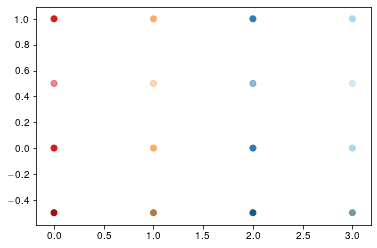

In [2]:
# Set tex formatting for plots
from matplotlib import rc
#rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

# Set legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
# Colors
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
base = ['#d7191c', '#fdae61', '#2c7bb6', '#abd9e9']
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
colors = to_rgb(base)
colorsa = to_rgb(base, a=0.5)
colorsb = to_rgb(base, b=0.7)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

In [3]:
def read_result(filename):
    if os.path.getsize(filename) > 0:
        with open(filename, "rb") as f:
            return pickle.load(f)

### Extract results

In [4]:
Ns=np.array([100,500,1000,10000])
runs = 50
def extract_metrics(files):
    all_metrics = {'ratio': np.zeros((len(Ns), runs)),
                   't1': np.zeros((len(Ns), runs)),
                   't2': np.zeros((len(Ns), runs)),
                    'correct': np.zeros((len(Ns), runs))}
    for file in files:
        args,truth,results = read_result(file)
        print(truth)
        (true_model, true_I) = truth[0]
        true_mec = utils.mec(true_model.A)
        true_imec = utils.imec(true_model.A, true_I)
        true_icpdag = utils.dag_to_icpdag(true_model.A, true_I)
        all_metrics['true_mec'] = true_mec
        all_metrics['true_imec'] = true_imec        
        i = np.where(Ns == args.n)[0][0]
        for run,_,result in results:
            (estimated_model, estimated_I, _), history, metrics, _elapsed = result    
            # Compute how often the true I-MEC is recovered
            estimated_icpdag = utils.dag_to_icpdag(estimated_model.A, estimated_I)
            all_metrics['correct'][i,run] = (estimated_icpdag == true_icpdag).all()
            
            # Compute how often a representative of the I-MEC is selected
            all_metrics['ratio'][i,run] = utils.member(true_imec, estimated_model.A) is not None

            # Compute t1/t2 metrics
            # estimate = utils.imec(estimated_model.A, estimated_I)
            # all_metrics['t1'][i,run] = ut_lvcm.metrics.type_1_structc(estimate, true_imec)
            # all_metrics['t2'][i,run] = ut_lvcm.metrics.type_2_structc(estimate, true_imec)
            metrics = dict(metrics)            
            all_metrics['t1'][i,run] = metrics[ut_lvcm.metrics.type_1_struct]
            all_metrics['t2'][i,run] = metrics[ut_lvcm.metrics.type_2_struct]
    return all_metrics

In [5]:
def figure_no_pruning(results, filename=None):
    w = 2.5
    plt.figure(figsize=(2*w,w*0.95), dpi=100)
    gs = gridspec.GridSpec(1, 2, wspace=0.07, hspace=0)
    markers = {100:'D', 500: 'o', 1000:'X', 10000:'.'}
    c = dict(zip([100,500,1000,10000], colors))
    cb = dict(zip([100,500,1000,10000], colorsb))

    # --------------------------------------------------
    # Histogram
    plt.subplot(gs[0])
    ax = plt.gca()
    ax.bar(range(len(Ns)), results['ratio'].mean(axis=1), color=colors, edgecolor=colorsb)
    ax.set_xticks(range(len(Ns)))
    ax.set_xticklabels([100, 500, '1K', '10K'])
    ax.set_xlabel("Obs. per environment (n)")
    ax.set_ylabel("Graph in true I-MEC\nwas best scoring (ratio)")
    ax.set_ylim([0,1.05])
    for i,ratio in enumerate(results['ratio'].mean(axis=1)):
        ax.text(i,ratio-0.1,"%0.2f" % ratio, ha='center',size=9)

    # --------------------------------------------------
    # t1/t2 metrics
    plt.subplot(gs[1])
    ax = plt.gca()

    # Plot
    x, y = results['t1'].mean(axis=1), 1-results['t2'].mean(axis=1)

    for i,n in enumerate(Ns):
        ax.plot(x[i],y[i], marker=markers[n], markerfacecolor=c[n], markeredgecolor=cb[n], zorder=10+n, clip_on=False, markersize=8)


    ax.set_ylim([0,1])
    ax.set_xlim([0,1])

    # Format
    ax.yaxis.tick_right()
    xticks = [0, 0.25, 0.5, 0.75, 1]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.set_xlabel("avg. FDP")
    ax.yaxis.set_label_position("right")
    ax.set_ylabel("avg. TDP")

    # Legend
    sample_size_entries = [Line2D([0], [0], linestyle='None', marker=markers[n], color=c[n], markeredgecolor=cb[n]) for n in markers.keys()]
    sample_size_str = ["n = %d" % n for n in markers.keys()]
    ax.legend(sample_size_entries,# + initial_point_entry,
              sample_size_str,# + ["True MEC"],
              prop={'size':8},
              loc='lower right',
              ncol=1)
              #bbox_to_anchor=(1.63,1.04))

    if filename is not None:
        plt.savefig("figures/" + filename, bbox_inches='tight')

## Figure 3a

In [6]:
files_baseline_2_rd_hs = [
"baseline_experiments/results_1688832642__seed:42_tag:fb2_disc:30_runs:50_no_edges:5_G:1_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:4_init:3_np:1_fh:None_n:100/compiled_results.pickle",
"baseline_experiments/results_1688832737__seed:42_tag:fb2_disc:30_runs:50_no_edges:5_G:1_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:4_init:3_np:1_fh:None_n:500/compiled_results.pickle",
"baseline_experiments/results_1688832741__seed:42_tag:fb2_disc:30_runs:50_no_edges:5_G:1_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:4_init:3_np:1_fh:None_n:1000/compiled_results.pickle",
"baseline_experiments/results_1688832744__seed:42_tag:fb2_disc:30_runs:50_no_edges:5_G:1_k:2.1_p:20_w_lo:0.6_w_hi:0.8_v_lo:0.5_v_hi:0.6_i_v_lo:6.0_i_v_hi:12.0_psi_lo:0.2_psi_hi:0.3_i_psi_lo:0.2_i_psi_hi:1.0_h:2_e:5_size_I:4_init:3_np:1_fh:None_n:10000/compiled_results.pickle"
]

In [7]:
%%time
metrics_baseline_2_rd_hs = extract_metrics(files_baseline_2_rd_hs)

[(<ut_lvcm.model.Model object at 0x7f4d9527ce10>, {16, 9, 3, 12})]
[(<ut_lvcm.model.Model object at 0x7f4d9527c208>, {16, 9, 3, 12})]
[(<ut_lvcm.model.Model object at 0x7f4d9527cf60>, {16, 9, 3, 12})]
[(<ut_lvcm.model.Model object at 0x7f4d9527cbe0>, {16, 9, 3, 12})]
CPU times: user 4.06 s, sys: 35.2 ms, total: 4.09 s
Wall time: 4.08 s


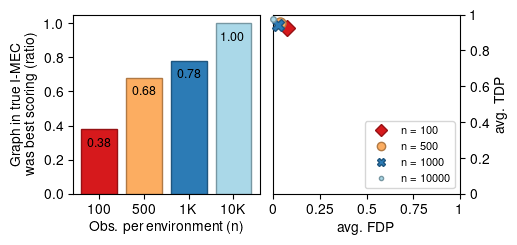

In [8]:
figure_no_pruning(metrics_baseline_2_rd_hs, "figure_baseline_2.pdf")